# Outbreak Simulator - Small: W=5

In [1]:
from SpatialScan.region import *
from SpatialScan.likelihood import *
from SpatialScan.results import *
from SpatialScan.scan import *
from SpatialScan.synthetic import *
from SpatialScan.timeseries import *
from SpatialScan.preprocessing import *

import pandas as pd

## Set Model Parameters

In [2]:
# Set these Variables First
OUTBREAK_LENGTH=5
NORMAL_ANALYSIS_DAYS=7
DAYS_IN_PAST=28
DAYS_IN_FUTURE=5

# Outbreak size
SEVERITY=8

LON_MIN = -0.349749335498348
LON_MAX = -0.25056950567589603
LAT_MIN = 51.45083323706079
LAT_MAX = 51.5408981075881

## Get Synthetic data from File

In [3]:
synth_df = pd.read_csv("../data/simulation/synthetic_scoot_april_june.csv", infer_datetime_format=True, parse_dates=[1, 4])
synth_df = synth_df[(synth_df['lon'].between(LON_MIN, LON_MAX)) & (synth_df['lat'].between(LAT_MIN, LAT_MAX))]

In [4]:
total_days_of_required_data = OUTBREAK_LENGTH + NORMAL_ANALYSIS_DAYS + DAYS_IN_PAST
total_days_of_required_data

40

In [5]:
t_min = synth_df['measurement_end_utc'].max() - np.timedelta64(total_days_of_required_data, 'D')
forecast_start = t_min + np.timedelta64(DAYS_IN_PAST, 'D')
first_analysis_day = forecast_start + np.timedelta64(DAYS_IN_FUTURE, 'D')
synth_df = synth_df[synth_df['measurement_start_utc'] >= t_min].copy()

Now have 40 days worth of data in Ealing

In [6]:
synth_df

detector_id measurement_end_utc       lon        lat  \
504      N24/002b1 2020-04-26 01:00:00 -0.285622  51.462133   
505      N24/002b1 2020-04-26 02:00:00 -0.285622  51.462133   
506      N24/002b1 2020-04-26 03:00:00 -0.285622  51.462133   
507      N24/002b1 2020-04-26 04:00:00 -0.285622  51.462133   
508      N24/002b1 2020-04-26 05:00:00 -0.285622  51.462133   
...            ...                 ...       ...        ...   
671971   N28/140g1 2020-06-04 20:00:00 -0.276751  51.538122   
671972   N28/140g1 2020-06-04 21:00:00 -0.276751  51.538122   
671973   N28/140g1 2020-06-04 22:00:00 -0.276751  51.538122   
671974   N28/140g1 2020-06-04 23:00:00 -0.276751  51.538122   
671975   N28/140g1 2020-06-05 00:00:00 -0.276751  51.538122   

       measurement_start_utc  n_vehicles_in_interval  rolling_threshold  \
504      2020-04-26 00:00:00                      29         247.292989   
505      2020-04-26 01:00:00                      33         247.983082   
506      2020-04-26 02:00:00                      12         247.845462   
507      2020-04-26 03:00:00                      17         248.284142   
508      2020-04-26 04:00:00                      74         249.285030   
...                      ...                     ...                ...   
671971   2020-06-04 19:00:00                     404        1339.610887   
671972   2020-06-04 20:00:00                     255        1337.103390   
671973   2020-06-04 21:00:00                      26        1340.919715   
671974   2020-06-04 22:00:00                     126        1343.364932   
671975   2020-06-04 23:00:00                      24        1340.796783   

        global_threshold  Num_Anom  Num_Missing  
504           308.356339       0.0           10  
505           308.356339       0.0           10  
506           308.356339       0.0           10  
507           308.356339       0.0           10  
508           308.356339       0.0           10  
...                  ...       ...          ...  
671971        972.069431       0.0            4  
671972        972.069431       0.0            4  
671973        972.069431       0.0            4  
671974        972.069431       0.0            4  
671975        972.069431       0.0            4  

[439680 rows x 10 columns]

## Get Historical Data from file (30 days with same settings for now)

In [7]:
hist = pd.read_csv('30_day_null_simulation_files/highest.csv')
hist.drop(['l_score_075', 'l_score_100'], axis=1, inplace=True)
hist.rename({'l_score_basic': 'l_score_EBP'}, inplace=True, axis=1)

In [8]:
hist.head(5)

x_min     x_max      y_min      y_max                t_min  \
0 -0.275364 -0.262967  51.528227  51.539188  2020-05-03 07:00:00   
1 -0.300159 -0.275364  51.495345  51.506306  2020-05-04 06:00:00   
2 -0.275364 -0.262967  51.517267  51.528227  2020-05-05 01:00:00   
3 -0.287762 -0.275364  51.506306  51.517267  2020-05-07 21:00:00   
4 -0.349749 -0.337352  51.451503  51.462464  2020-05-08 23:00:00   

                 t_max  l_score_EBP  l_score_000  l_score_025  l_score_050  \
0  2020-05-05 00:00:00     1.000358     0.000518     0.000032    -0.000086   
1  2020-05-06 00:00:00     1.000201     0.000492    -0.000043    -0.001000   
2  2020-05-07 00:00:00     1.000442     0.001460    -0.000074    -0.002445   
3  2020-05-08 00:00:00     1.000227     0.000266     0.000192     0.000138   
4  2020-05-09 00:00:00     1.000083     0.000104     0.000072     0.000049   

                   day  
0  2020-05-05 00:00:00  
1  2020-05-06 00:00:00  
2  2020-05-07 00:00:00  
3  2020-05-08 00:00:00  
4  2020-05-09 00:00:00

## Simulate an Outbreak which lasts for the last `OUTBREAK_LENGTH` days

In [9]:
outbreak_df, outbreak_detectors, outbreak_start = simulate_outbreak(synth_df, severity=SEVERITY, k_min=1, k_max=75, outbreak_duration=OUTBREAK_LENGTH)

Outbreak centred at (-0.295034837756049, 51.5321338356957) affecting 50 detectors
['N27/130b1' 'N27/101q1' 'N27/102b1' 'N27/101c1' 'N27/101a1' 'N27/101a2'
 'N27/102a1' 'N27/101b2' 'N27/101b1' 'N27/102x2' 'N27/100c1' 'N27/100x1'
 'N27/004b1' 'N27/100b1' 'N27/100s1' 'N27/004a1' 'N27/130a1' 'N27/130a2'
 'N27/004x2' 'N27/102c2' 'N27/004f3' 'N27/004g1' 'N27/004g2' 'N27/004f1'
 'N27/004f2' 'N27/010d1' 'N27/093e1' 'N27/010c1' 'N27/245b1' 'N27/011a1'
 'N27/018b1' 'N27/247x1' 'N27/169a1' 'N27/018e1' 'N28/140g1' 'N27/247a1'
 'N27/071a1' 'N27/018f1' 'N27/247f1' 'N27/247e1' 'N27/090b1' 'N27/169b1'
 'N27/011d1' 'N27/093g1' 'N27/018d1' 'N27/169c1' 'N27/219b1' 'N27/219b2'
 'N27/044c1' 'N27/011h1']
Start of outbreak: 2020-05-31 00:00:00


Text(2020-05-29 00:00:00, 1500, 'Analysis Begins')

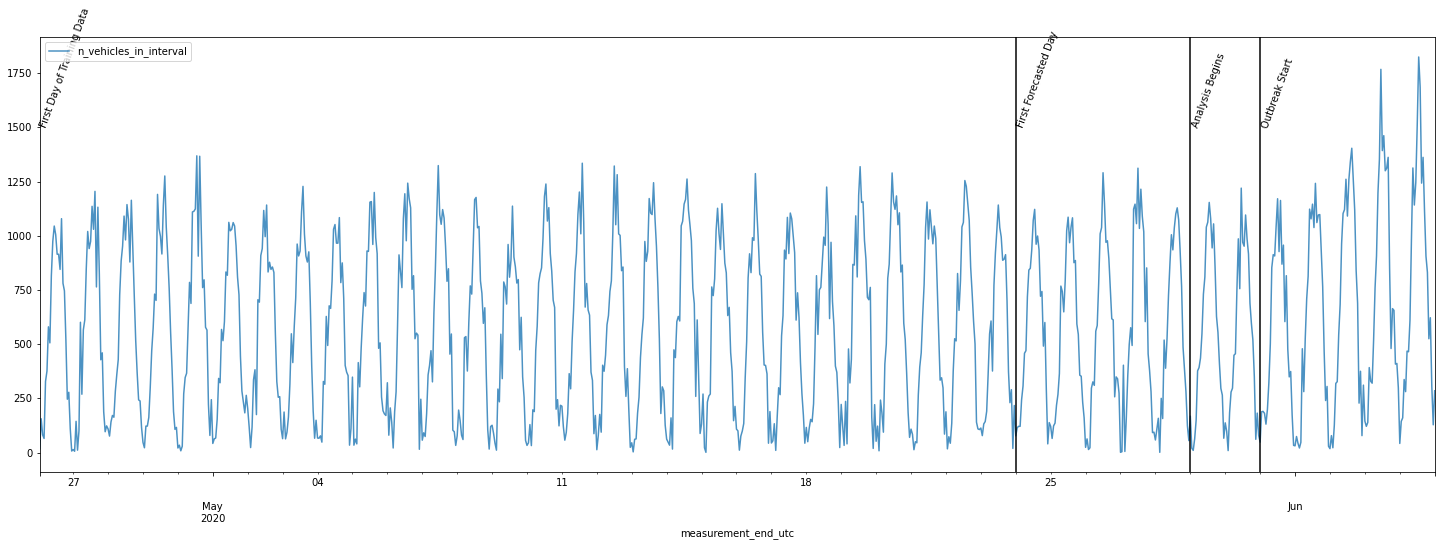

In [10]:
outbreak_df[outbreak_df['detector_id'] == 'N27/011a1'].plot(x='measurement_end_utc', y='n_vehicles_in_interval', figsize=(25, 8), alpha=0.8)
plt.axvline(x=outbreak_start, c='k')
plt.text(outbreak_start,1500,'Outbreak Start',rotation=70, size=10)

plt.axvline(x=t_min, c='k')
plt.text(t_min,1500,'First Day of Training Data',rotation=70, size=10)

plt.axvline(x=forecast_start, c='k')
plt.text(forecast_start ,1500,'First Forecasted Day',rotation=70, size=10)

plt.axvline(x=first_analysis_day, c='k')
plt.text(first_analysis_day,1500,'Analysis Begins',rotation=70, size=10)

Total number of days in dataframe:  40
Producing forecasts and scans for 8 days in total.

Outbreak begins at 2020-05-31 00:00:00.

Analysis day: 2020-05-29 00:00:00. Looking back at last 120 hours.
Input dataframe contains data spanning 2020-04-26 00:00:00 to 2020-05-29 00:00:00.
Using data from 2020-04-26 00:00:00 to 2020-05-24 00:00:00, to forecast counts
 between 2020-05-24 00:00:00 and 2020-05-29 00:00:00 for 458 detectors using HW method...
Forecasting complete.
Dates in datetime format. Moving to next stage.

0 NaN values found in 'count' column. Dropping these from the dataframe.
0 NaN values found in 'baseline' column. Dropping these from the dataframe.

All baseline predictions >= 0.

Data cleansing complete. 0 rows removed from dataframe.


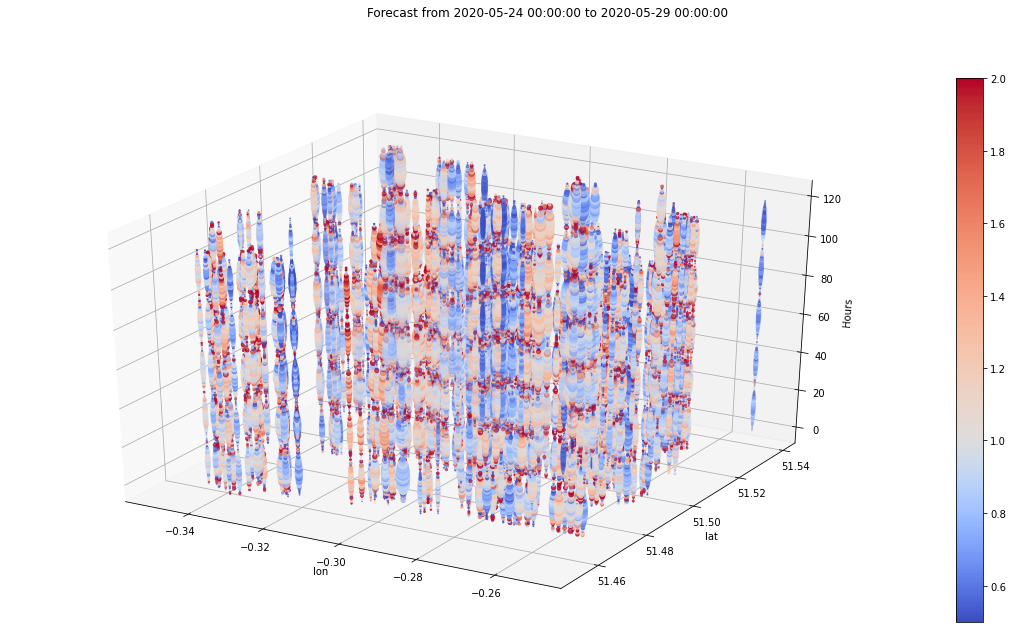

Aggregating data from detector level to grid level.
Beginning normal scan. Setup Time: 23.08 seconds
Search spatial regions with t_min = 2020-05-24 00:00:00 and t_max = 2020-05-29 00:00:00
No Outbreak Posterior: 0.9936230880463484
Total Outbreak Posterior: 0.006376911953651592

81120 space-time regions searched in 253.02 seconds
Total run time: 276.10 seconds


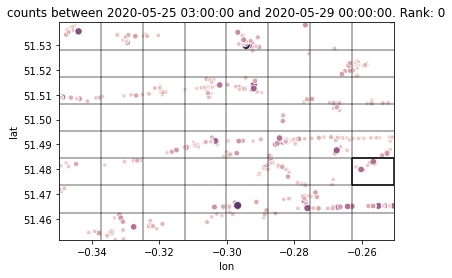


Analysis day: 2020-05-30 00:00:00. Looking back at last 120 hours.
Input dataframe contains data spanning 2020-04-26 00:00:00 to 2020-05-30 00:00:00.
Using data from 2020-04-27 00:00:00 to 2020-05-25 00:00:00, to forecast counts
 between 2020-05-25 00:00:00 and 2020-05-30 00:00:00 for 458 detectors using HW method...
Forecasting complete.
Dates in datetime format. Moving to next stage.

0 NaN values found in 'count' column. Dropping these from the dataframe.
0 NaN values found in 'baseline' column. Dropping these from the dataframe.

All baseline predictions >= 0.

Data cleansing complete. 0 rows removed from dataframe.


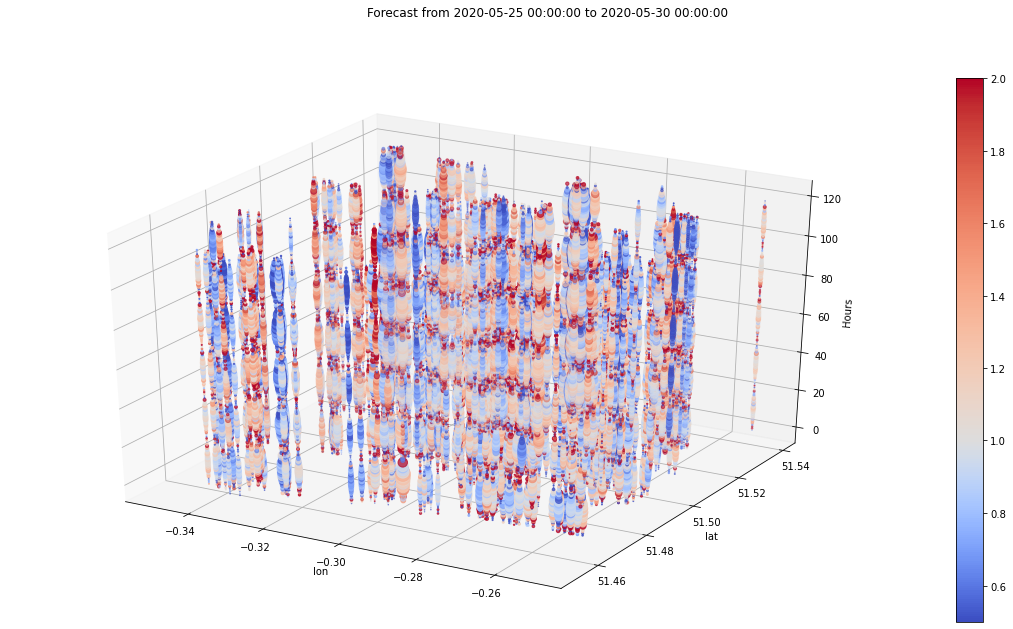

Aggregating data from detector level to grid level.
Beginning normal scan. Setup Time: 25.32 seconds
Search spatial regions with t_min = 2020-05-25 00:00:00 and t_max = 2020-05-30 00:00:00
No Outbreak Posterior: 0.9936285434447168
Total Outbreak Posterior: 0.006371456555283152

81120 space-time regions searched in 241.49 seconds
Total run time: 266.81 seconds


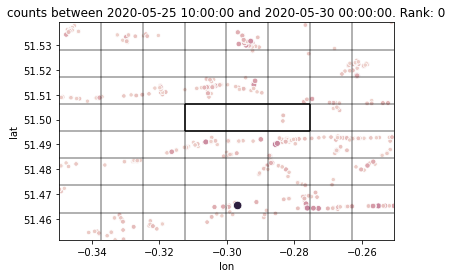


Analysis day: 2020-05-31 00:00:00. Looking back at last 120 hours.
Input dataframe contains data spanning 2020-04-26 00:00:00 to 2020-05-31 00:00:00.
Using data from 2020-04-28 00:00:00 to 2020-05-26 00:00:00, to forecast counts
 between 2020-05-26 00:00:00 and 2020-05-31 00:00:00 for 458 detectors using HW method...
Forecasting complete.
Dates in datetime format. Moving to next stage.

0 NaN values found in 'count' column. Dropping these from the dataframe.
0 NaN values found in 'baseline' column. Dropping these from the dataframe.

All baseline predictions >= 0.

Data cleansing complete. 0 rows removed from dataframe.


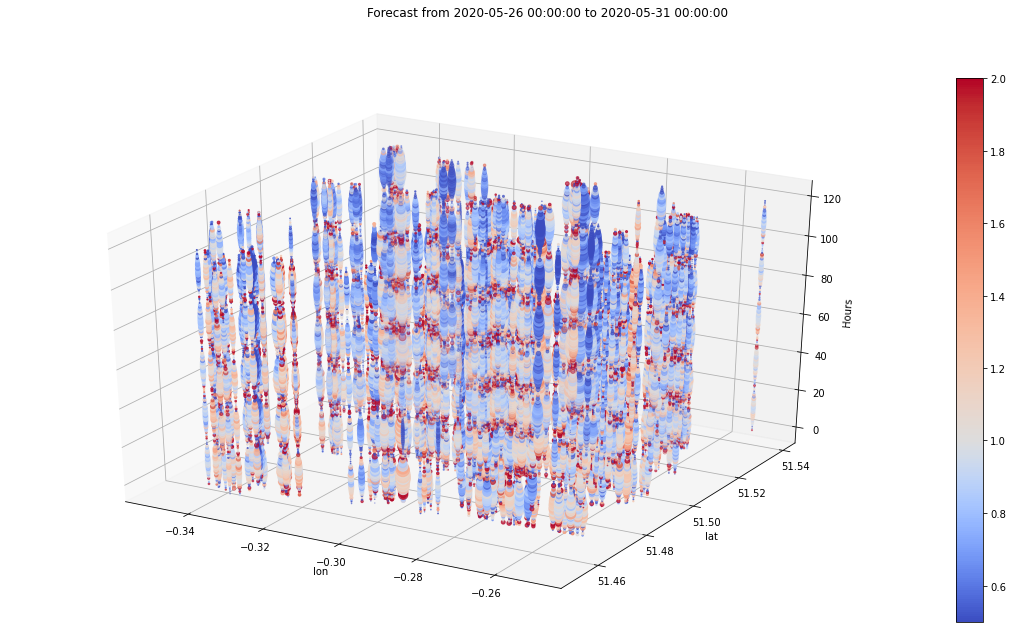

Aggregating data from detector level to grid level.
Beginning normal scan. Setup Time: 23.64 seconds
Search spatial regions with t_min = 2020-05-26 00:00:00 and t_max = 2020-05-31 00:00:00
No Outbreak Posterior: 0.9936003173266269
Total Outbreak Posterior: 0.006399682673373095

81120 space-time regions searched in 241.73 seconds
Total run time: 265.36 seconds


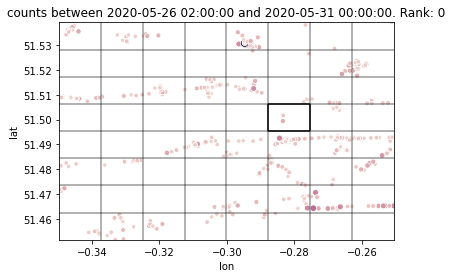


Analysis day: 2020-06-01 00:00:00. Looking back at last 120 hours.
Input dataframe contains data spanning 2020-04-26 00:00:00 to 2020-06-01 00:00:00.
Using data from 2020-04-29 00:00:00 to 2020-05-27 00:00:00, to forecast counts
 between 2020-05-27 00:00:00 and 2020-06-01 00:00:00 for 458 detectors using HW method...
Forecasting complete.
Dates in datetime format. Moving to next stage.

0 NaN values found in 'count' column. Dropping these from the dataframe.
0 NaN values found in 'baseline' column. Dropping these from the dataframe.

All baseline predictions >= 0.

Data cleansing complete. 0 rows removed from dataframe.


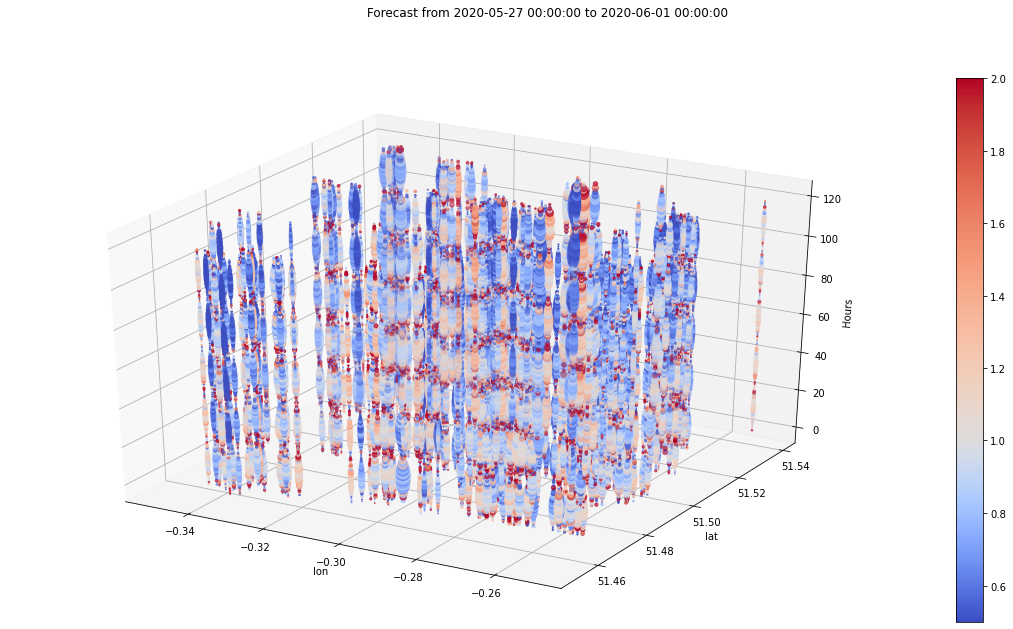

Aggregating data from detector level to grid level.
Beginning normal scan. Setup Time: 25.02 seconds
Search spatial regions with t_min = 2020-05-27 00:00:00 and t_max = 2020-06-01 00:00:00
No Outbreak Posterior: 0.9936599484131331
Total Outbreak Posterior: 0.0063400515868669025

81120 space-time regions searched in 245.91 seconds
Total run time: 270.93 seconds


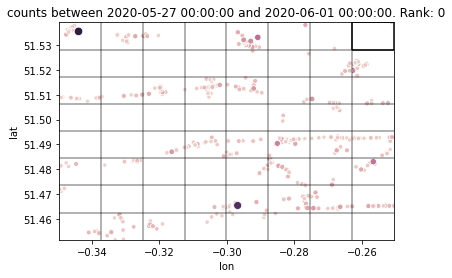


Analysis day: 2020-06-02 00:00:00. Looking back at last 120 hours.
Input dataframe contains data spanning 2020-04-26 00:00:00 to 2020-06-02 00:00:00.
Using data from 2020-04-30 00:00:00 to 2020-05-28 00:00:00, to forecast counts
 between 2020-05-28 00:00:00 and 2020-06-02 00:00:00 for 458 detectors using HW method...
Forecasting complete.
Dates in datetime format. Moving to next stage.

0 NaN values found in 'count' column. Dropping these from the dataframe.
0 NaN values found in 'baseline' column. Dropping these from the dataframe.

All baseline predictions >= 0.

Data cleansing complete. 0 rows removed from dataframe.


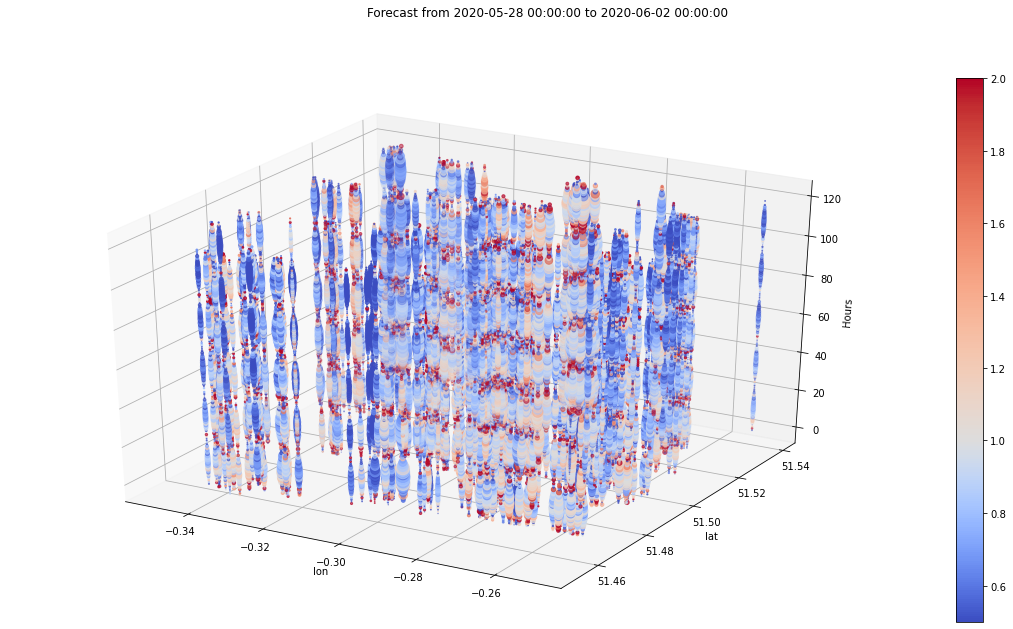

Aggregating data from detector level to grid level.
Beginning normal scan. Setup Time: 24.36 seconds
Search spatial regions with t_min = 2020-05-28 00:00:00 and t_max = 2020-06-02 00:00:00
No Outbreak Posterior: 0.9936625162847799
Total Outbreak Posterior: 0.006337483715220111

81120 space-time regions searched in 244.59 seconds
Total run time: 268.95 seconds


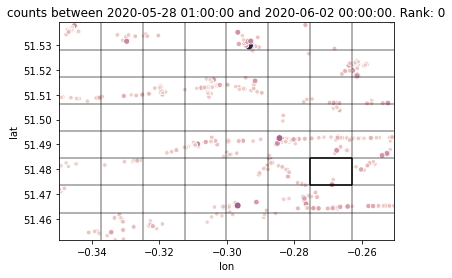


Analysis day: 2020-06-03 00:00:00. Looking back at last 120 hours.
Input dataframe contains data spanning 2020-04-26 00:00:00 to 2020-06-03 00:00:00.
Using data from 2020-05-01 00:00:00 to 2020-05-29 00:00:00, to forecast counts
 between 2020-05-29 00:00:00 and 2020-06-03 00:00:00 for 458 detectors using HW method...
Forecasting complete.
Dates in datetime format. Moving to next stage.

0 NaN values found in 'count' column. Dropping these from the dataframe.
0 NaN values found in 'baseline' column. Dropping these from the dataframe.

All baseline predictions >= 0.

Data cleansing complete. 0 rows removed from dataframe.


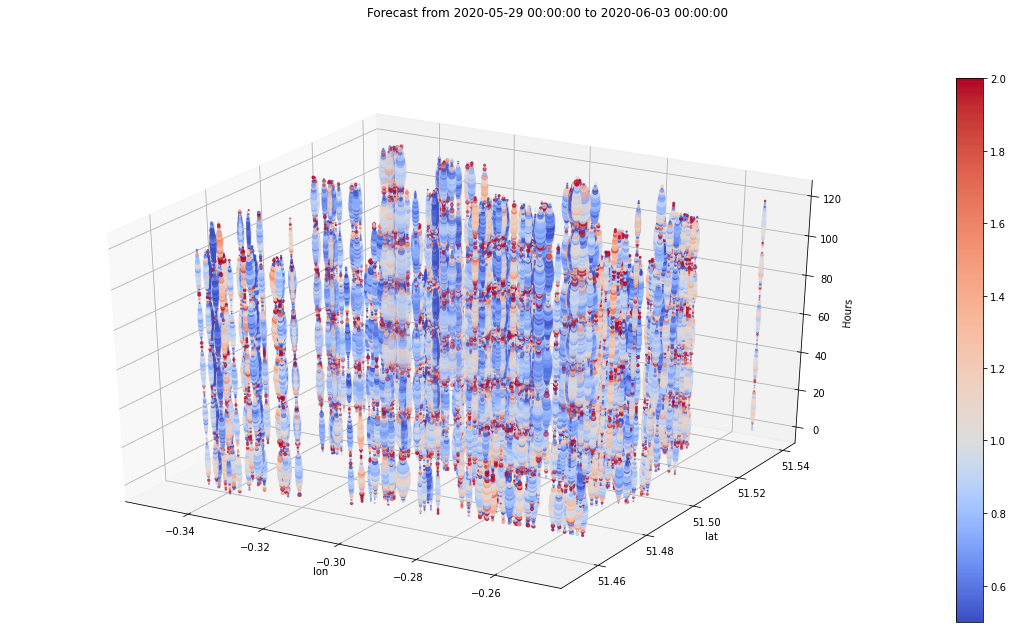

Aggregating data from detector level to grid level.
Beginning normal scan. Setup Time: 23.24 seconds
Search spatial regions with t_min = 2020-05-29 00:00:00 and t_max = 2020-06-03 00:00:00
No Outbreak Posterior: 0.993677437250871
Total Outbreak Posterior: 0.0063225627491289805

81120 space-time regions searched in 240.55 seconds
Total run time: 263.80 seconds


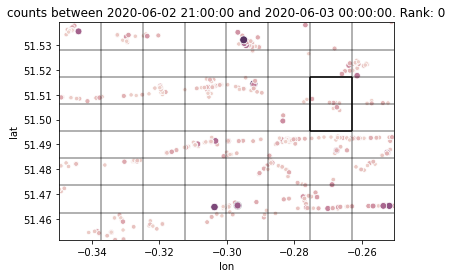


Analysis day: 2020-06-04 00:00:00. Looking back at last 120 hours.
Input dataframe contains data spanning 2020-04-26 00:00:00 to 2020-06-04 00:00:00.
Using data from 2020-05-02 00:00:00 to 2020-05-30 00:00:00, to forecast counts
 between 2020-05-30 00:00:00 and 2020-06-04 00:00:00 for 458 detectors using HW method...
Forecasting complete.
Dates in datetime format. Moving to next stage.

0 NaN values found in 'count' column. Dropping these from the dataframe.
0 NaN values found in 'baseline' column. Dropping these from the dataframe.

All baseline predictions >= 0.

Data cleansing complete. 0 rows removed from dataframe.


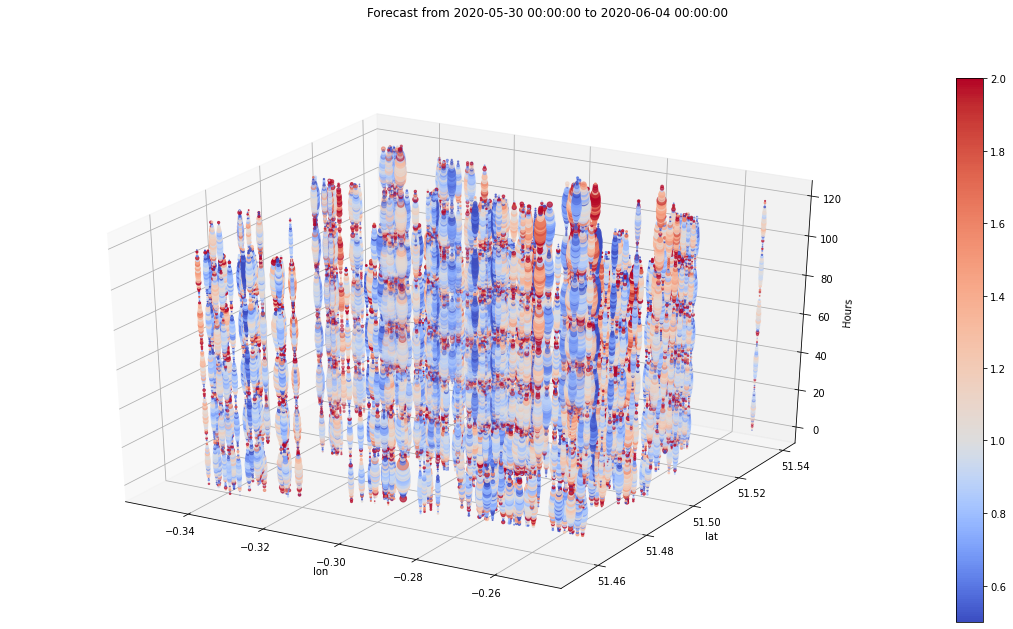

Aggregating data from detector level to grid level.
Beginning normal scan. Setup Time: 22.13 seconds
Search spatial regions with t_min = 2020-05-30 00:00:00 and t_max = 2020-06-04 00:00:00
No Outbreak Posterior: 0.9936341236510794
Total Outbreak Posterior: 0.006365876348920616

81120 space-time regions searched in 232.23 seconds
Total run time: 254.37 seconds


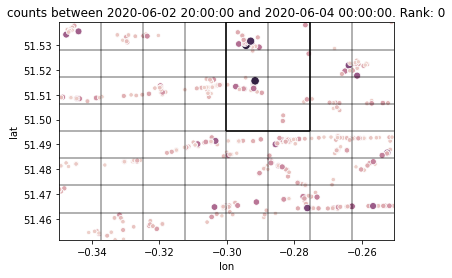


Analysis day: 2020-06-05 00:00:00. Looking back at last 120 hours.
Input dataframe contains data spanning 2020-04-26 00:00:00 to 2020-06-05 00:00:00.
Using data from 2020-05-03 00:00:00 to 2020-05-31 00:00:00, to forecast counts
 between 2020-05-31 00:00:00 and 2020-06-05 00:00:00 for 458 detectors using HW method...
Forecasting complete.
Dates in datetime format. Moving to next stage.

0 NaN values found in 'count' column. Dropping these from the dataframe.
0 NaN values found in 'baseline' column. Dropping these from the dataframe.

All baseline predictions >= 0.

Data cleansing complete. 0 rows removed from dataframe.


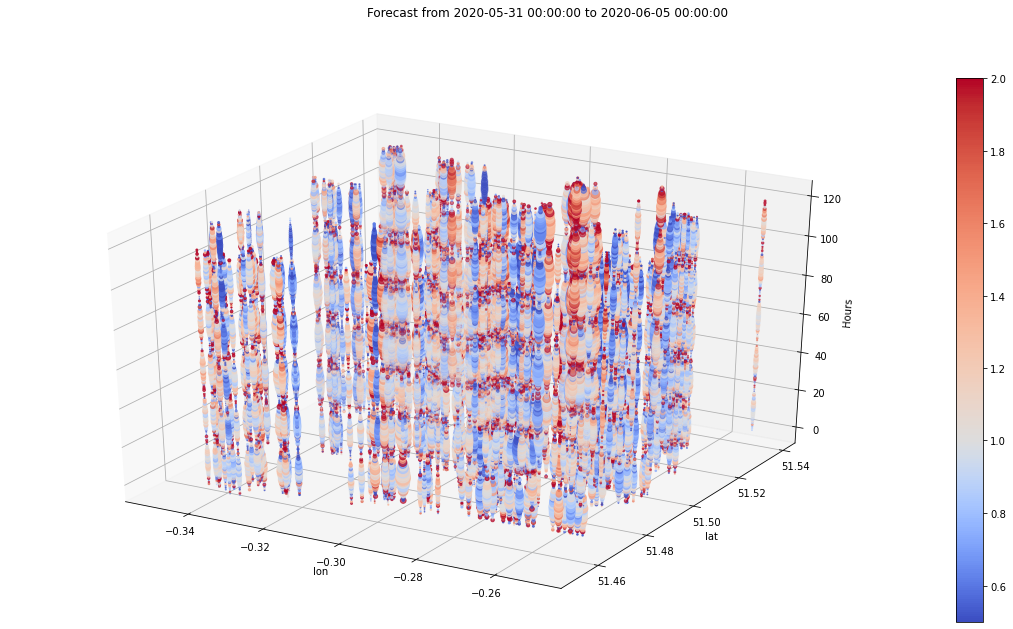

Aggregating data from detector level to grid level.
Beginning normal scan. Setup Time: 23.46 seconds
Search spatial regions with t_min = 2020-05-31 00:00:00 and t_max = 2020-06-05 00:00:00
No Outbreak Posterior: 0.9936212934641678
Total Outbreak Posterior: 0.006378706535832171

81120 space-time regions searched in 242.71 seconds
Total run time: 266.17 seconds


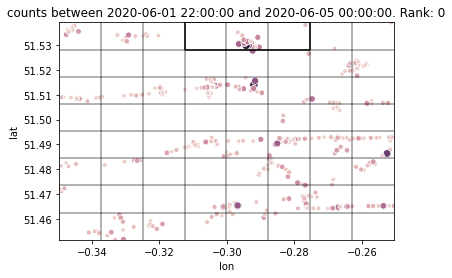

In [11]:
database_results, highest_regions = results_builder(outbreak_df, outbreak_detectors, outbreak_start, hist,
                                                    days_in_past=DAYS_IN_PAST, days_in_future=DAYS_IN_FUTURE, method='HW',
                                                    grid_partition=8, scan_type='normal', show_plots=True)

In [12]:
database_results

start_time_utc end_time_utc  point_id     x_min     x_max  \
0     2020-05-24 00:00:00   2020-05-29         0 -0.349749 -0.337352   
1     2020-05-24 00:00:00   2020-05-29         1 -0.337352 -0.324954   
2     2020-05-24 00:00:00   2020-05-29         2 -0.324954 -0.312557   
3     2020-05-24 00:00:00   2020-05-29         3 -0.312557 -0.300159   
4     2020-05-24 00:00:00   2020-05-29         4 -0.300159 -0.287762   
...                   ...          ...       ...       ...       ...   
18427 2020-06-04 23:00:00   2020-06-05        59 -0.312557 -0.300159   
18428 2020-06-04 23:00:00   2020-06-05        60 -0.300159 -0.287762   
18429 2020-06-04 23:00:00   2020-06-05        61 -0.287762 -0.275364   
18430 2020-06-04 23:00:00   2020-06-05        62 -0.275364 -0.262967   
18431 2020-06-04 23:00:00   2020-06-05        63 -0.262967 -0.250570   

           y_min      y_max  observed_count  forecasted_count  \
0      51.451503  51.462464       12.038689         12.420891   
1      51.451503  51.462464       25.811866         26.902537   
2      51.451503  51.462464       38.204804         40.513929   
3      51.451503  51.462464       52.382849         55.648909   
4      51.451503  51.462464       65.613254         70.487226   
...          ...        ...             ...               ...   
18427  51.528227  51.539188        0.095894          0.089820   
18428  51.528227  51.539188        0.132908          0.120858   
18429  51.528227  51.539188        0.087548          0.082282   
18430  51.528227  51.539188        0.053190          0.054836   
18431  51.528227  51.539188        0.025362          0.027681   

       av_lhd_score_EBP  av_lhd_score_eps_000  av_lhd_score_eps_025  \
0              1.000002              0.000803             -0.011647   
1              1.000005              0.000657             -0.015791   
2              1.000000              0.000210             -0.021113   
3              1.000045              0.000398             -0.024757   
4              1.000019              0.000082             -0.032987   
...                 ...                   ...                   ...   
18427          1.000012              0.000023             -0.000026   
18428          1.000020              0.000042             -0.000014   
18429          1.000014              0.000024             -0.000028   
18430          1.000004             -0.000006             -0.000066   
18431          1.000004             -0.000007             -0.000072   

       av_lhd_score_eps_050  av_posterior_bbayes  
0                 -0.049694         8.435320e-08  
1                 -0.063505         8.140377e-08  
2                 -0.077261         8.031222e-08  
3                 -0.089453         7.663278e-08  
4                 -0.112300         7.257574e-08  
...                     ...                  ...  
18427             -0.000124         7.983461e-08  
18428             -0.000122         7.727418e-08  
18429             -0.000126         7.766453e-08  
18430             -0.000182         8.187995e-08  
18431             -0.000193         7.872917e-08  

[18432 rows x 14 columns]

In [14]:
highest_regions2 = highest_regions.drop(['F_thresh_fp=0.05', 'F_thresh_fp=0.10', 'F_thresh_fp=0.25', 'F_thresh_fp=0.01', 'F_thresh_fp=0.50',
                                         'detected_fp=0.01', 'posterior_bbayes'], axis=1)
highest_regions2

x_min     x_max      y_min      y_max               t_min      t_max  \
0 -0.262967 -0.250570  51.473424  51.484385 2020-05-25 03:00:00 2020-05-29   
1 -0.312557 -0.275364  51.495345  51.506306 2020-05-25 10:00:00 2020-05-30   
2 -0.287762 -0.275364  51.495345  51.506306 2020-05-26 02:00:00 2020-05-31   
3 -0.262967 -0.250570  51.528227  51.539188 2020-05-27 00:00:00 2020-06-01   
4 -0.275364 -0.262967  51.473424  51.484385 2020-05-28 01:00:00 2020-06-02   
5 -0.275364 -0.262967  51.495345  51.517267 2020-06-02 21:00:00 2020-06-03   
6 -0.300159 -0.275364  51.495345  51.539188 2020-06-02 20:00:00 2020-06-04   
7 -0.312557 -0.275364  51.528227  51.539188 2020-06-01 22:00:00 2020-06-05   

   l_score_EBP  l_score_000  l_score_025  l_score_050  precision  recall  \
0     1.001756     0.003727     0.000003    -0.002498   0.000000    0.00   
1     1.002664     0.004666     0.000632    -0.000157   0.000000    0.00   
2     1.001470     0.004635     0.000549    -0.000241   0.000000    0.00   
3     1.000055     0.000596     0.000071    -0.000030   0.000000    0.00   
4     1.000296     0.003412     0.000587    -0.000031   0.000000    0.00   
5     1.000150     0.000293     0.000147     0.000061   0.000000    0.00   
6     1.001758     0.008122    -0.000239    -0.011506   0.869565    0.80   
7     1.005434     0.012854    -0.000753    -0.022308   1.000000    0.48   

         day  days_since_outbreak  detected_fp=0.05  detected_fp=0.10  \
0 2020-05-29                   -2              True              True   
1 2020-05-30                   -1              True              True   
2 2020-05-31                    0              True              True   
3 2020-06-01                    1             False             False   
4 2020-06-02                    2             False             False   
5 2020-06-03                    3             False             False   
6 2020-06-04                    4              True              True   
7 2020-06-05                    5              True              True   

   detected_fp=0.25  detected_fp=0.50  
0              True              True  
1              True              True  
2              True              True  
3             False             False  
4             False              True  
5             False             False  
6              True              True  
7              True              True

In [ ]:
visualise_results_from_database(database_results)